<h2>Dataset Loading</h2>

In [1]:
# Importing necessary libraries for handling the data
import pandas as pd

# Loading the datasets provided
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
depression_comments = pd.read_csv('depression_comments.csv')
suicidewatch_comments = pd.read_csv('SuicideWatch_comments.csv')


# Combining all posts datasets into a single DataFrame 'df_posts'
df_posts = pd.concat([suicidewatch_posts,depression_posts], ignore_index=True)

df_posts = df_posts.drop(columns=['Flair'])


# Combining all comments datasets into a single DataFrame 'df_comments'
df_comments = pd.concat([suicidewatch_comments,depression_comments], ignore_index=True)

# Displaying the structure of the combined datasets to confirm the merge
df_posts_shape = df_posts.shape
df_comments_shape = df_comments.shape

df_posts_head = df_posts.head()
df_comments_head = df_comments.head()

df_posts_shape, df_comments_shape, df_posts_head, df_comments_head


((10000, 8),
 (23042, 7),
                    User                                         Post Title  \
 0         gktqkbcnbr_jj           I just don’t care and want to end things   
 1        Sad_Cancel_705         I’ve decided to kill myself in 30 minutes    
 2           Thatmaa4986                      Suicidal at 34 weeks pregnant   
 3  Expensive_Flounder28  I finally figured out which way I'm going to k...   
 4  MalsAdaptiveDreaming  Thinking of jumping off a bridge above water. ...   
 
                                              Content  Score  Comments Count  \
 0                                                NaN      1               0   
 1  I 19m just wants someone to talk to before I d...      2               0   
 2  (28F) I am 34 weeks pregnant and struglling wi...      4               1   
 3  I'm going to wait until a very cold winter nig...      2               0   
 4  I wonder what the lethality is for 20-25 feet ...      1               0   
 
    Upvote Ratio

<h2>Data Preprocessing</h2>

https://www.mdpi.com/1660-4601/19/19/12635

This step aims to filter textual posts to eliminate noise before applying feature extraction and embedding techniques, and to produce a word vector for classification. It includes stop word removal, punctuation removal, lowercasing, tokenization, and lemmatization. We employed the Natural Language Toolkit (NLTK) [34] and performed basic tasks to preprocess the dataset.
Punctuation, emoji, and numerical digit removal: this process removes the characters “?, !, :, ;, ’,” and emoji to make the text easily processable.

<b>Stop word removal</b>: this process removes words such as “the”, “a”, “an”, and “in”, which have no contribution to the operation of the model.

<b>Lowercasing</b>: this process lowercases all words.

<b>Tokenization</b>: this process splits each sentence into its basic parts, such as words, phrases, and other pieces of information.

<b>Lemmatization</b>: this process combines inflected forms of words into their root form.


In [2]:
# Import required libraries
import re

from nltk.corpus import stopwords
import nltk
import spacy
# Download stopwords if not already available
#nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Define a comprehensive data cleaning function
def preprocess_text(text, remove_stopwords=True, convert_emojis=False):
    # Convert non-string entries to an empty string
    if not isinstance(text, str):
        text = ""
    # Remove URLs, emails, newline symbols, and HTML tags
    text = re.sub(r'http\S+|www.\S+|\b\w+@\w+\.\w+\b|<.*?>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Optionally handle emojis
    if convert_emojis:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '[EMOJI]', text)  # Converts emojis to [EMOJI] label
    else:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Removes emojis
    # Convert to lowercase
    text = text.lower()
    # Process text with SpaCy and optionally remove stopwords
    doc = nlp(text)
    if remove_stopwords:
        return ' '.join([token.lemma_ for token in doc if token.text not in stop_words])
    else:
        return ' '.join([token.lemma_ for token in doc])

# Apply this cleaning function to text columns in your datasets
df_posts['Content'] = df_posts['Content'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))
df_comments['Comment Body'] = df_comments['Comment Body'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))


<h3>Tokenization</h3>

In [3]:
# Importing necessary libraries for tokenization
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy

# Downloading NLTK resources if not already available
#nltk.download('punkt')
#nltk.download('punkt_tab')
# Loading SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform tokenization
def tokenize_text(text, level='word', method='spacy'):
    """
    Tokenizes text based on specified level and method.

    Parameters:
    - text (str): Input text to be tokenized.
    - level (str): 'word' for word-level tokenization or 'sentence' for sentence-level tokenization.
    - method (str): 'spacy' for SpaCy tokenization, 'nltk' for NLTK tokenization.

    Returns:
    - list: List of tokens at the specified level.
    """
    if not isinstance(text, str):
        return []  # Return empty list if text is not a valid string
    
    if method == 'spacy':
        doc = nlp(text)
        if level == 'word':
            tokens = [token.text for token in doc]
        elif level == 'sentence':
            tokens = [sent.text for sent in doc.sents]
    elif method == 'nltk':
        if level == 'word':
            tokens = word_tokenize(text)
        elif level == 'sentence':
            tokens = sent_tokenize(text)
    
    return tokens

# Applying tokenization on 'Content' in posts and 'Comment Body' in comments

# For posts - SpaCy word-level and sentence-level tokenization
df_posts['SpaCy_Word_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='word', method='spacy'))
df_posts['SpaCy_Sentence_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='sentence', method='spacy'))

# For comments - NLTK word-level and sentence-level tokenization
df_comments['NLTK_Word_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='word', method='nltk'))
df_comments['NLTK_Sentence_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='sentence', method='nltk'))


<h3>lemmatization</h3>

In [4]:
# Import necessary libraries
import re
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions  # Import contractions module

# Load SpaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Initialize Porter Stemmer for stemming if needed
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess_text(text, lemmatize=True, use_stemming=False, correct_spelling=False, expand_contractions=True):
    """
    Cleans and preprocesses text by lemmatizing or stemming, with optional spell correction and contraction expansion.
    
    Parameters:
    - text (str): The text to be processed.
    - lemmatize (bool): Whether to apply lemmatization (default is True).
    - use_stemming (bool): Whether to apply stemming (default is False).
    - correct_spelling (bool): Whether to perform spell correction (default is False).
    - expand_contractions (bool): Whether to expand contractions (default is True).
    
    Returns:
    - str: The processed text.
    """
    # Expand contractions if specified
    if expand_contractions:
        text = contractions.fix(text)

    # Convert text to lowercase
    text = text.lower()

    # Spell correction (optional)
    if correct_spelling:
        text = str(TextBlob(text).correct())

    # Tokenize and apply lemmatization or stemming
    processed_tokens = []
    if lemmatize:
        # Lemmatization using SpaCy
        doc = nlp(text)
        processed_tokens = [token.lemma_ for token in doc]
    elif use_stemming:
        # Stemming using NLTK
        words = text.split()
        processed_tokens = [stemmer.stem(word) for word in words]
    else:
        # If neither lemmatization nor stemming, just split the text
        processed_tokens = text.split()

    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Example usage: Concatenate title and body, apply preprocessing
df_posts['Processed_Text'] = df_posts.apply(
    lambda row: preprocess_text(f"{row['Post Title']} {row['Content']}", 
                                lemmatize=True, 
                                correct_spelling=False, 
                                expand_contractions=True),
    axis=1
)

<h2>Data Exploration</h2>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

To understand suicidal individuals, we analysed the words, languages, and topics in online user content.

<h4>WordCloud</h4>


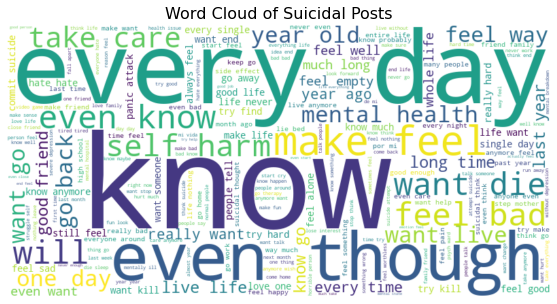

In [5]:
# Importing necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed text from posts into one large string
all_text = ' '.join(df_posts['Processed_Text'])

# Generate the WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(all_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Suicidal Posts', fontsize=16)
plt.show()

<h3>LDA</h3>

In [6]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics
num_topics = 10

# Create a CountVectorizer to transform text into a bag-of-words representation
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df_posts['Processed_Text'])

# Perform Latent Dirichlet Allocation (LDA)
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Extract the top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx + 1] = top_features
    return topics

# Get the feature names and extract topics
feature_names = vectorizer.get_feature_names_out()
topics = get_top_words(lda_model, feature_names)

# Display the topics
for topic, words in topics.items():
    print(f"Topic {topic}: {', '.join(words)}")

Topic 1: feel, want, like, life, know, make, really, live, people, year
Topic 2: life, feel, know, like, bad, people, hate, think, time, live
Topic 3: feel, like, time, think, work, want, make, know, pain, try
Topic 4: feel, know, like, talk, want, think, people, help, really, suicide
Topic 5: que, mi, por, la, lo, eh, feel, dad, vida, es
Topic 6: feel, like, know, bad, year, think, leave, tell, time, make
Topic 7: feel, like, want, know, life, love, try, hate, good, way
Topic 8: school, feel, day, hate, think, love, work, like, people, year
Topic 9: want, life, anymore, day, like, fuck, die, wish, know, time
Topic 10: feel, like, friend, know, talk, day, think, want, really, thing


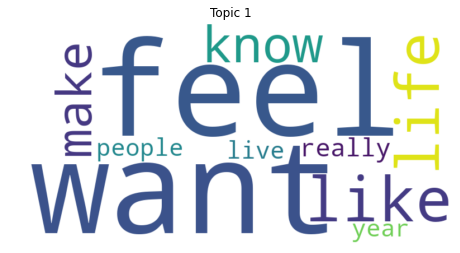

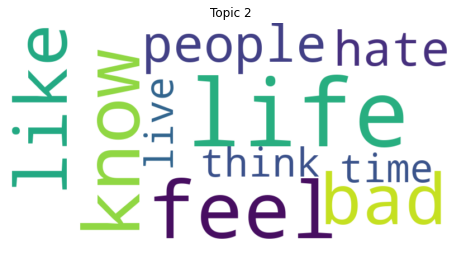

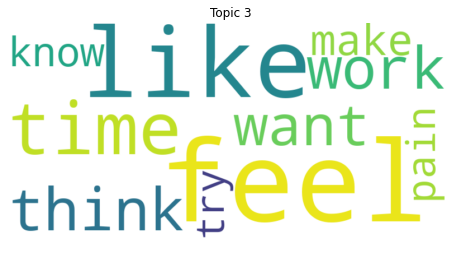

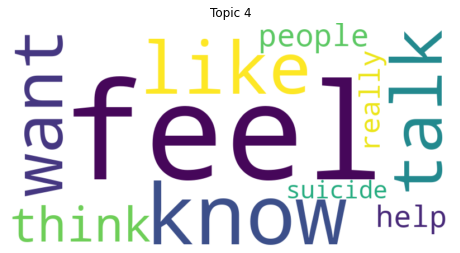

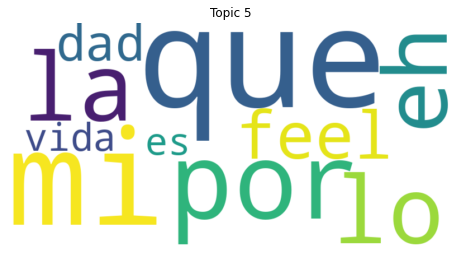

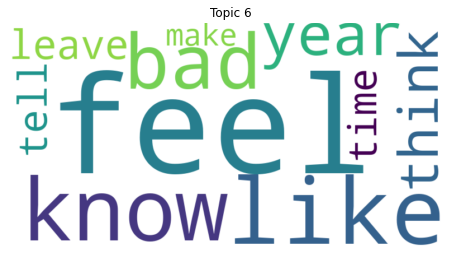

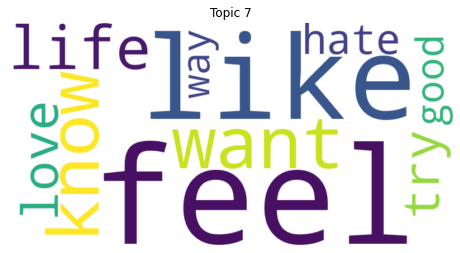

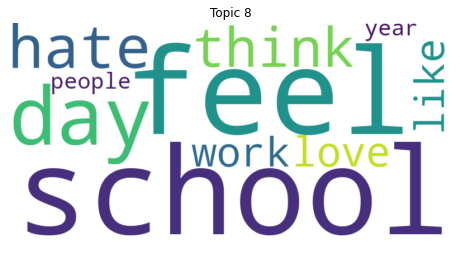

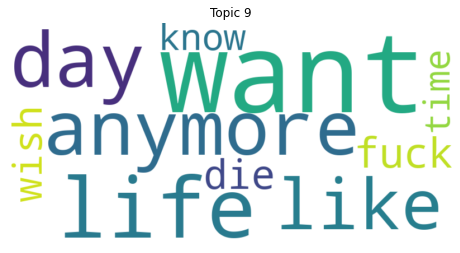

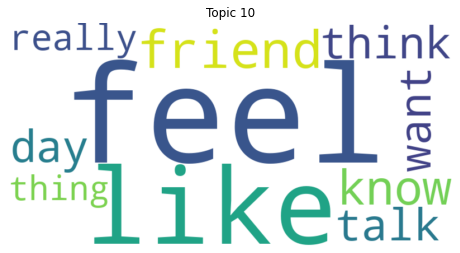

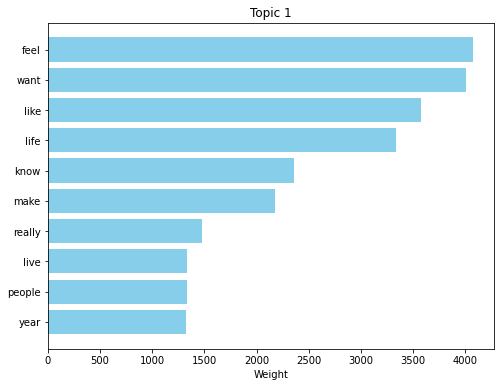

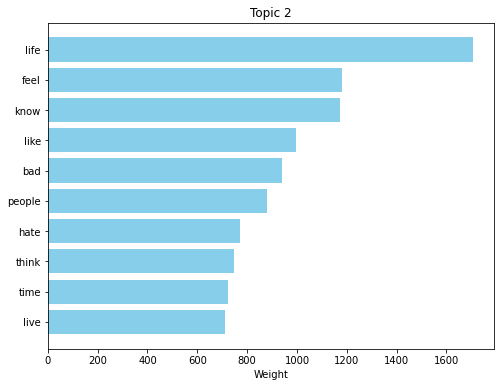

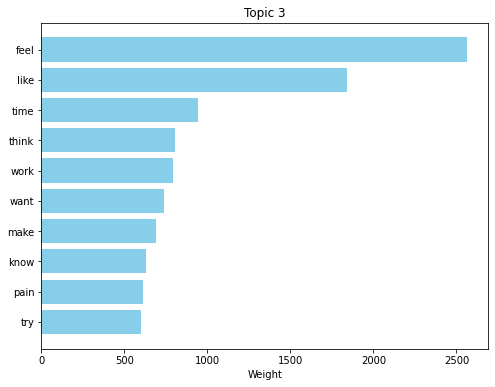

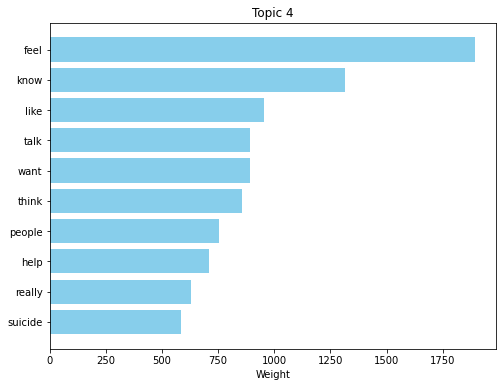

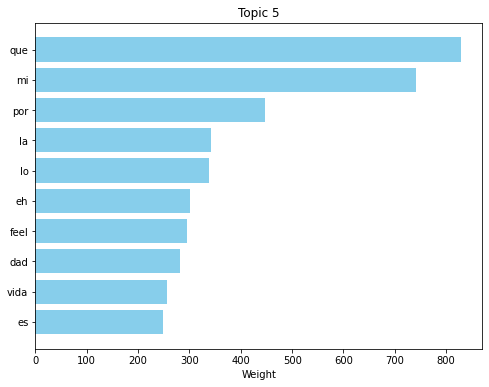

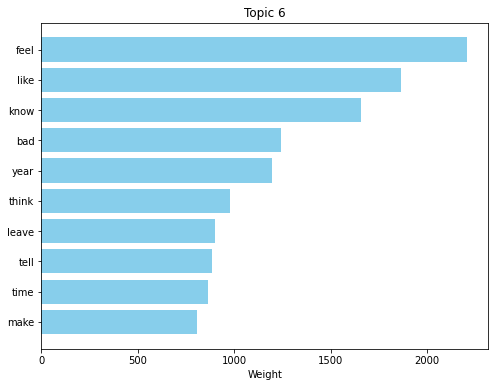

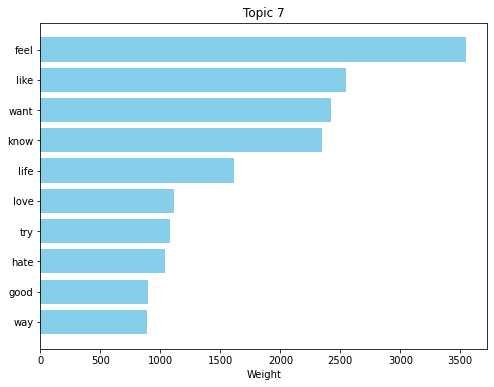

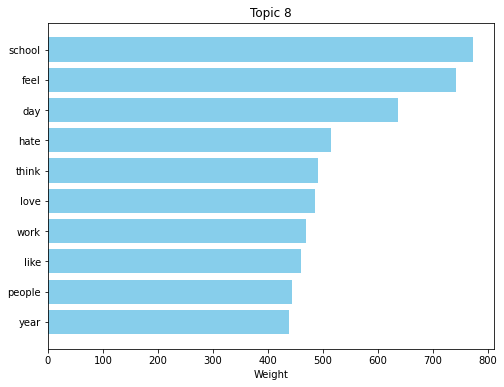

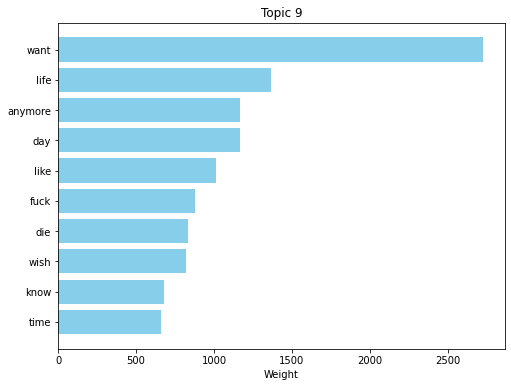

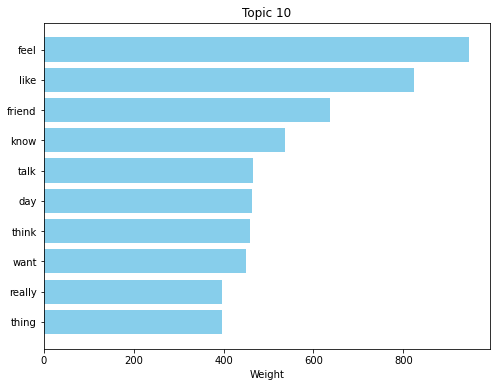

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Function to visualize topics as word clouds
def plot_lda_topics_as_wordcloud(model, feature_names, num_topics, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for each topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]
        
        # Create a dictionary for word cloud
        wordcloud_data = dict(zip(top_words, top_weights))
        
        # Create a word cloud for the current topic
        plt.figure(figsize=(8, 6))
        plt.title(f'Topic {topic_idx + 1}')
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# Function to plot bar charts for the top words in each topic
def plot_lda_topics_as_barchart(model, feature_names, num_topics, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for each topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]
        
        # Create a bar plot for top words
        plt.figure(figsize=(8, 6))
        plt.barh(top_words, top_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Topic {topic_idx + 1}')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest weight at the top
        plt.show()

# Visualize the topics using WordCloud
plot_lda_topics_as_wordcloud(lda_model, feature_names, num_topics)

# Visualize the topics using Bar Chart
plot_lda_topics_as_barchart(lda_model, feature_names, num_topics)


In [8]:
# Import the LIWC categories
from liwc_categories import liwc_categories

# Function to calculate LIWC-like statistics
def calculate_liwc_stats(texts, categories):
    stats = {key: 0 for key in categories.keys()}
    total_words = 0

    for text in texts:
        words = word_tokenize(text.lower())
        total_words += len(words)
        
        for category, words_list in categories.items():
            stats[category] += sum(1 for word in words if word in words_list)
    
    # Convert counts to average per text
    for key in stats.keys():
        stats[key] /= len(texts)
    
    stats["average_word_count"] = total_words / len(texts)
    return stats

# Analyze your dataset
texts = df_posts['Processed_Text']  # Assuming this column contains cleaned text
liwc_stats = calculate_liwc_stats(texts, liwc_categories)

# Display the results
import pandas as pd
liwc_stats_df = pd.DataFrame([liwc_stats])
print(liwc_stats_df)



   personal_pronouns  quantifiers  positive_emotion  negative_emotion  \
0             4.6004       1.5328            0.9958            1.1716   

   anxiety   death  swear_words  family  friend  female_references  \
0   0.2717  1.0641        0.385  1.5103  0.6636             0.5634   

   male_references    work  money  past_focus  present_focus  future_focus  \
0           0.4409  0.7714    0.4      0.1368        15.0255        2.7059   

   average_word_count  
0             95.8159  


<h2>Adding labels to datasets</h2>

<h4>Posts label</h4>

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify Risk_Level
def classify_risk_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score <= -0.85:  # Strongly negative
        return 'High'
    elif -0.6 < sentiment_score <= -0.2:  # Moderately negative
        return 'Moderate'
    else:  # Neutral or positive
        return 'Low'

# Apply to the dataset
df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_16559/3319806549.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm')


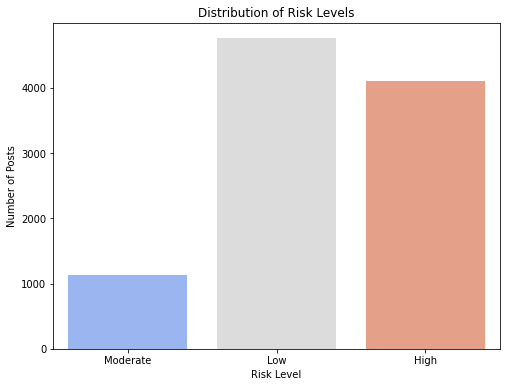

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of the Risk_Level column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Posts')
plt.show()


<h3>Analysis of Risk Level</h3>

https://www.sciencedirect.com/science/article/pii/S1319157821003244

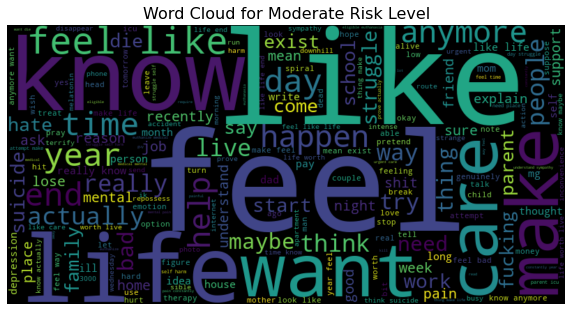

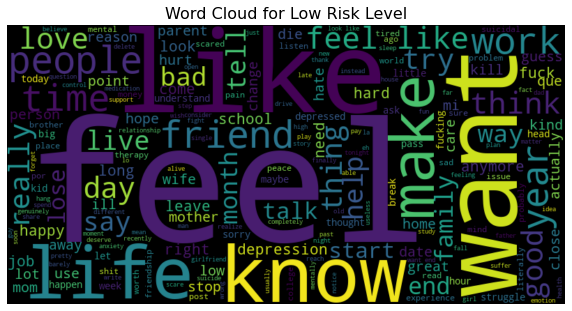

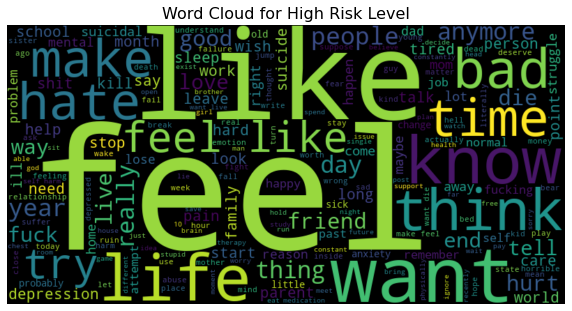

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

# Load your dataset (ensure `df_posts` contains 'Processed_Text' and 'Risk_Level')
df_posts['Risk_Level'] = df_posts['Risk_Level'].fillna('No Risk')  # Handle missing labels

# Define a function to extract n-grams
def extract_ngrams(texts, n=1):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(texts)
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = ngram_counts.toarray().sum(axis=0)
    return dict(zip(ngram_features, ngram_frequencies))

# Generate word clouds for each risk level
risk_levels = df_posts['Risk_Level'].unique()

# Mapping numerical risk levels to their names
risk_level_mapping = {0: "Low", 1: "Moderate", 2: "High"}

for risk_level in risk_levels:
    # Filter the posts for the specific risk level
    texts = df_posts[df_posts['Risk_Level'] == risk_level]['Processed_Text'].dropna()
    
    # Extract n-grams
    unigram_counts = extract_ngrams(texts, n=1)
    bigram_counts = extract_ngrams(texts, n=2)
    trigram_counts = extract_ngrams(texts, n=3)
    
    # Combine all n-grams into a single dictionary
    combined_counts = Counter(unigram_counts) + Counter(bigram_counts) + Counter(trigram_counts)
    
    # Get the top 300 n-grams
    top_ngrams = dict(combined_counts.most_common(300))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_ngrams)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {risk_level_mapping[risk_level]} Risk Level', fontsize=16)
    plt.axis('off')
    plt.show()

<h4>Comments empathy label</h4>

In [11]:
# Define a function to classify Empathy_Level
def classify_empathy_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score > 0.5:  # Strongly positive
        return 'High'
    elif -0.2 <= sentiment_score <= 0.5:  # Neutral to slightly positive
        return 'Neutral'
    else:  # Negative sentiment
        return 'Low'

# Apply to the comments dataset
df_comments['Empathy_Level'] = df_comments['Comment Body'].apply(classify_empathy_level)


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_16559/1428913615.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_comments, x='Empathy_Level', palette='coolwarm')


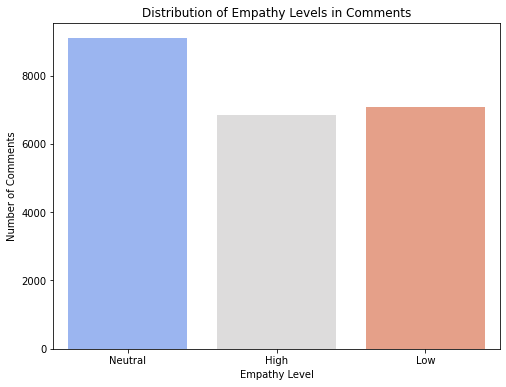

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of the Empathy_Level column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_comments, x='Empathy_Level', palette='coolwarm')
plt.title('Distribution of Empathy Levels in Comments')
plt.xlabel('Empathy Level')
plt.ylabel('Number of Comments')
plt.show()


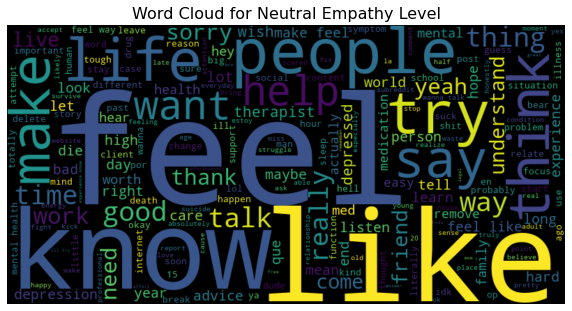

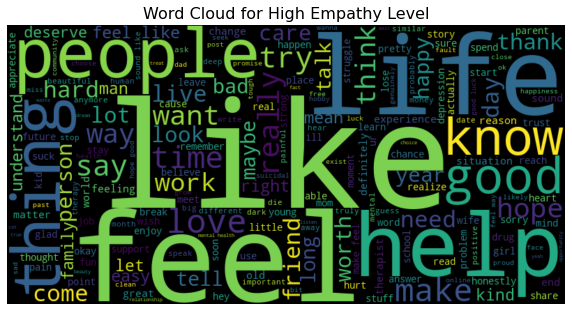

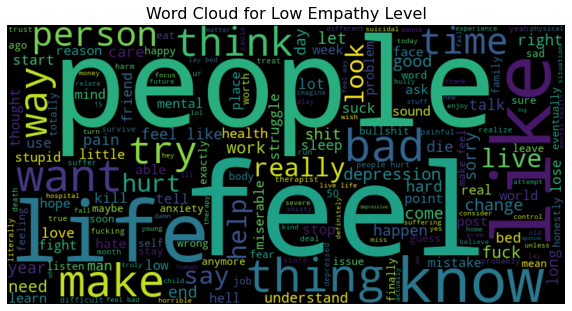

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

# Ensure 'Empathy_Level' column is filled appropriately
df_comments['Empathy_Level'] = df_comments['Empathy_Level'].fillna('No Empathy')  # Handle missing labels

# Define a function to extract n-grams
def extract_ngrams(texts, n=1):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(texts)
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = ngram_counts.toarray().sum(axis=0)
    return dict(zip(ngram_features, ngram_frequencies))

# Generate word clouds for each empathy level
empathy_levels = df_comments['Empathy_Level'].unique()

for empathy_level in empathy_levels:
    # Filter the comments for the specific empathy level
    texts = df_comments[df_comments['Empathy_Level'] == empathy_level]['Comment Body'].dropna()
    
    # Extract n-grams
    unigram_counts = extract_ngrams(texts, n=1)
    bigram_counts = extract_ngrams(texts, n=2)
    trigram_counts = extract_ngrams(texts, n=3)
    
    # Combine all n-grams into a single dictionary
    combined_counts = Counter(unigram_counts) + Counter(bigram_counts) + Counter(trigram_counts)
    
    # Get the top 300 n-grams
    top_ngrams = dict(combined_counts.most_common(300))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_ngrams)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {empathy_level} Empathy Level', fontsize=16)
    plt.axis('off')
    plt.show()

<h2>Word Embedding+feature engineering</h2>

https://www.mdpi.com/1660-4601/19/19/12635

<h4>TF-IDF + word2Vec </h4>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

statistical features +topic features

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10666498

ngram features

https://www.mdpi.com/1660-4601/19/19/12635

LIWC features



In [21]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download required NLTK data files
nltk.download('punkt')

# Function to compute the statistical features
def compute_text_statistics(title, body):
    # Title statistics
    title_words = word_tokenize(title)
    title_tokens = len(title_words)
    title_chars = len(title)
    title_word_count = len([word for word in title_words if word.isalpha()])

    # Body statistics
    body_words = word_tokenize(body)
    body_tokens = len(body_words)
    body_chars = len(body)
    body_word_count = len([word for word in body_words if word.isalpha()])
    body_sentences = len(sent_tokenize(body))
    body_paragraphs = len(body.split('\n'))  # Assuming paragraphs are separated by new lines

    return {
        'Title_Word_Count': title_word_count,
        'Title_Token_Count': title_tokens,
        'Title_Char_Count': title_chars,
        'Body_Word_Count': body_word_count,
        'Body_Token_Count': body_tokens,
        'Body_Char_Count': body_chars,
        'Body_Sentence_Count': body_sentences,
        'Body_Paragraph_Count': body_paragraphs
    }

# Apply the function to each post and store the results in new columns
df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
          'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
          'Body_Sentence_Count', 'Body_Paragraph_Count']] = df_posts.apply(
    lambda row: pd.Series(compute_text_statistics(row['Post Title'], row['Processed_Text'])), axis=1)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rakibabdullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Use CountVectorizer to create a term-document matrix
count_vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = count_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Apply LDA to extract topics
num_topics = 10  # You can choose the number of topics based on your analysis
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(dtm)  # This will give us the topic probabilities for each post

# lda_topics will be a matrix of shape (n_posts, n_topics)
# Each row corresponds to a post, and each column represents the probability of the post belonging to a particular topic


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Generate TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Train Word2Vec model or load a pre-trained model
word2vec_model = Word2Vec(sentences=[text.split() for text in df_posts['Processed_Text']], vector_size=100, window=5, min_count=1, workers=4)

# Function to get Word2Vec embeddings for a document (average word vectors)
def get_word2vec_embedding(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Apply Word2Vec embeddings
word2vec_embeddings = df_posts['Processed_Text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Step 3: Combine TF-IDF and Word2Vec features
# Convert word2vec embeddings to an array
word2vec_matrix = np.array(word2vec_embeddings.tolist())

# Step 3: Combine TF-IDF, Word2Vec, and Statistical features

# Extract statistical features into a numpy array
statistical_features = df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
                                 'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
                                 'Body_Sentence_Count', 'Body_Paragraph_Count']].values

# The topic features (lda_topics) are the probability distributions over the topics for each post
#topic_features = lda_model

# Step 5: N-gram features (specifically trigrams)
# ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')  # We are using only trigrams here
# ngram_matrix = ngram_vectorizer.fit_transform(df_posts['Processed_Text'])


# Now concatenate TF-IDF, Word2Vec, and statistical features
# Combine all features: TF-IDF, Word2Vec, Statistical, and Topic features,ngram features
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features,lda_topics])

# You can now use the combined_features for further machine learning tasks


<h3>LIWC featuers</h3>

https://www.mdpi.com/1660-4601/19/19/12635


In [26]:
from liwc_categories import liwc_categories  # Assuming you have a file/module with LIWC categories

from nltk.tokenize import word_tokenize

def calculate_liwc_features(text, categories):
    """
    Calculate LIWC-like features for a single text.
    
    Parameters:
    - text (str): The text to process.
    - categories (dict): Dictionary of LIWC categories and their associated words.
    
    Returns:
    - dict: A dictionary with counts for each LIWC category.
    """
    liwc_counts = {category: 0 for category in categories.keys()}
    words = word_tokenize(text.lower())  # Tokenize and lowercase the text

    # Count occurrences for each LIWC category
    for category, words_list in categories.items():
        liwc_counts[category] = sum(1 for word in words if word in words_list)

    # Normalize counts by the number of words in the text
    total_words = len(words)
    if total_words > 0:
        liwc_counts = {key: value / total_words for key, value in liwc_counts.items()}
    else:
        liwc_counts = {key: 0 for key in liwc_counts.keys()}

    return liwc_counts

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Extract LIWC features into a numpy array
liwc_features_array = df_posts[liwc_features_df.columns].values

# Combine LIWC features with other feature matrices (e.g., TF-IDF, Word2Vec, etc.)
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features, lda_topics, liwc_features_array])

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_16559/3300007264.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=liwc_means_suicidal.values, y=liwc_means_suicidal.index, palette='viridis')


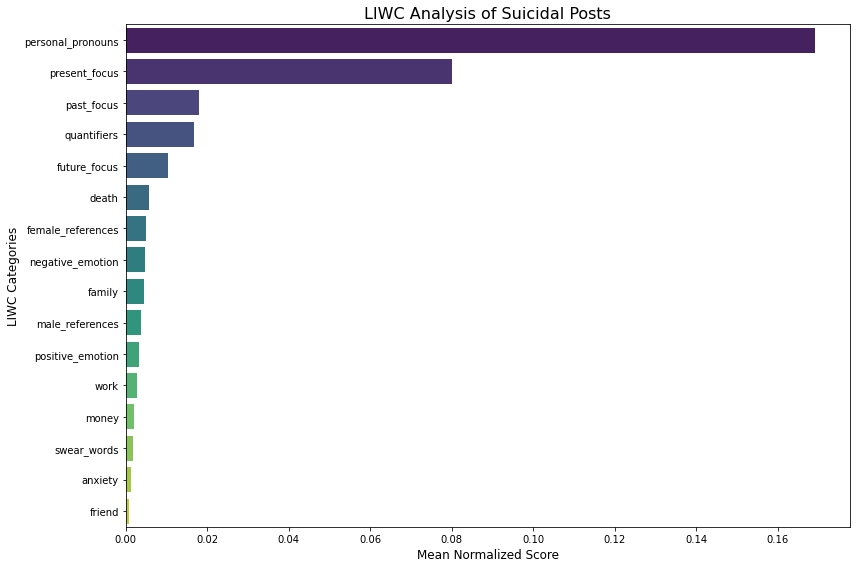

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_16559/3300007264.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=liwc_means_non_suicidal.values, y=liwc_means_non_suicidal.index, palette='viridis')


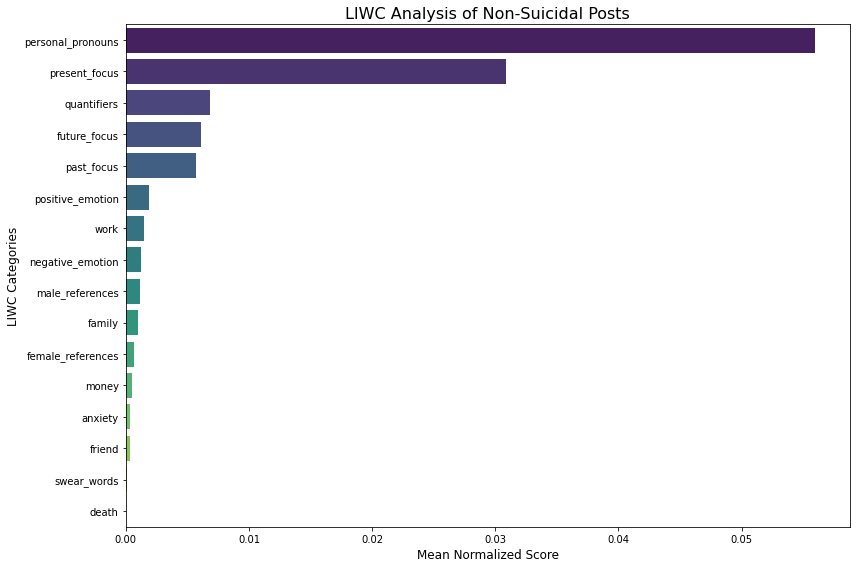

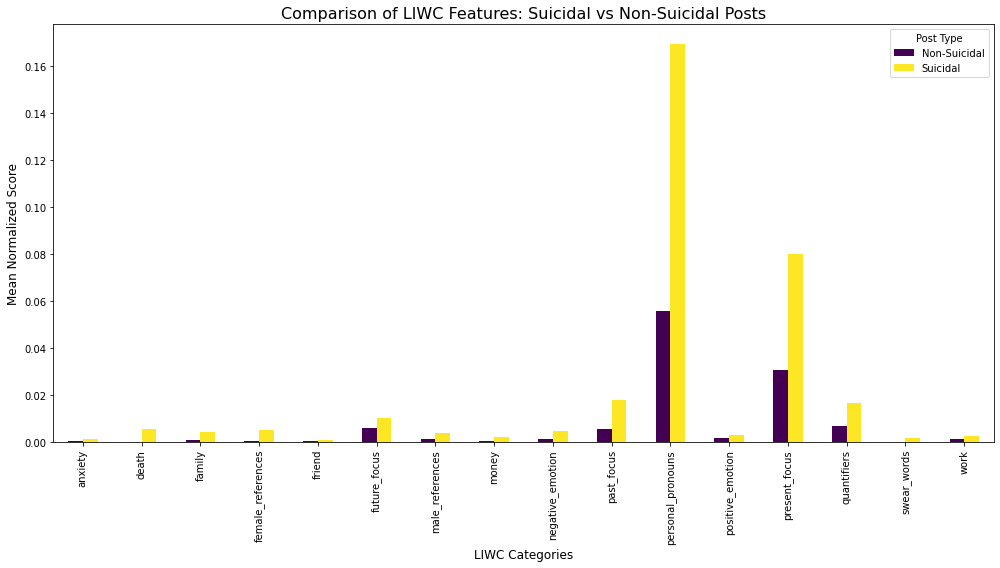

In [41]:
# Import necessary libraries
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
askreddit_posts = pd.read_csv('AskReddit_posts.csv')
getmotivated_posts = pd.read_csv('GetMotivated_posts.csv')

# Combine suicidal posts into a single DataFrame
suicidal_posts_df = pd.concat([suicidewatch_posts, depression_posts], ignore_index=True)

# Combine non-suicidal posts into a single DataFrame
non_suicidal_posts_df = pd.concat([askreddit_posts, getmotivated_posts], ignore_index=True)

# Ensure necessary columns are present
suicidal_posts_df['Processed_Text'] = suicidal_posts_df['Content'].fillna('')  # Replace NaN with empty string
non_suicidal_posts_df['Processed_Text'] = non_suicidal_posts_df['Content'].fillna('')  # Replace NaN with empty string

# Load LIWC categories
from liwc_categories import liwc_categories  # Assuming this module has LIWC categories

# Define a function to calculate LIWC features
def calculate_liwc_features(text, categories):
    """
    Calculate LIWC-like features for a single text.
    
    Parameters:
    - text (str): The text to process.
    - categories (dict): Dictionary of LIWC categories and their associated words.
    
    Returns:
    - dict: A dictionary with counts for each LIWC category.
    """
    liwc_counts = {category: 0 for category in categories.keys()}
    words = word_tokenize(text.lower())  # Tokenize and lowercase the text

    # Count occurrences for each LIWC category
    for category, words_list in categories.items():
        liwc_counts[category] = sum(1 for word in words if word in words_list)

    # Normalize counts by the number of words in the text
    total_words = len(words)
    if total_words > 0:
        liwc_counts = {key: value / total_words for key, value in liwc_counts.items()}
    else:
        liwc_counts = {key: 0 for key in liwc_counts.keys()}

    return liwc_counts

# Ensure all text is processed as strings
suicidal_posts_df['Processed_Text'] = suicidal_posts_df['Processed_Text'].astype(str)
non_suicidal_posts_df['Processed_Text'] = non_suicidal_posts_df['Processed_Text'].astype(str)

# Apply LIWC analysis to suicidal and non-suicidal posts
liwc_features_suicidal = suicidal_posts_df['Processed_Text'].apply(
    lambda x: calculate_liwc_features(x, liwc_categories)
)
liwc_features_non_suicidal = non_suicidal_posts_df['Processed_Text'].apply(
    lambda x: calculate_liwc_features(x, liwc_categories)
)

# Convert LIWC features to DataFrames
liwc_features_df_suicidal = pd.DataFrame(liwc_features_suicidal.tolist())
liwc_features_df_non_suicidal = pd.DataFrame(liwc_features_non_suicidal.tolist())

# Combine LIWC features with the original DataFrames
suicidal_posts_df = pd.concat([suicidal_posts_df, liwc_features_df_suicidal], axis=1)
non_suicidal_posts_df = pd.concat([non_suicidal_posts_df, liwc_features_df_non_suicidal], axis=1)

# Perform statistical analysis (mean values of LIWC features for visualization)
liwc_means_suicidal = liwc_features_df_suicidal.mean().sort_values(ascending=False)
liwc_means_non_suicidal = liwc_features_df_non_suicidal.mean().sort_values(ascending=False)


# Plot the LIWC features for suicidal posts
plt.figure(figsize=(12, 8))
sns.barplot(x=liwc_means_suicidal.values, y=liwc_means_suicidal.index, palette='viridis')
plt.title('LIWC Analysis of Suicidal Posts', fontsize=16)
plt.xlabel('Mean Normalized Score', fontsize=12)
plt.ylabel('LIWC Categories', fontsize=12)
plt.tight_layout()
plt.show()


# Plot the LIWC features for non-suicidal posts
plt.figure(figsize=(12, 8))
sns.barplot(x=liwc_means_non_suicidal.values, y=liwc_means_non_suicidal.index, palette='viridis')
plt.title('LIWC Analysis of Non-Suicidal Posts', fontsize=16)
plt.xlabel('Mean Normalized Score', fontsize=12)
plt.ylabel('LIWC Categories', fontsize=12)
plt.tight_layout()
plt.show()

# Comparison: Suicidal vs Non-Suicidal LIWC Features
# Combine the means for comparison
liwc_comparison = pd.DataFrame({
    'Non-Suicidal': liwc_means_non_suicidal,
    'Suicidal': liwc_means_suicidal
})

# Plot the comparison
liwc_comparison.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Comparison of LIWC Features: Suicidal vs Non-Suicidal Posts', fontsize=16)
plt.xlabel('LIWC Categories', fontsize=12)
plt.ylabel('Mean Normalized Score', fontsize=12)
plt.legend(title='Post Type', loc='upper right')
plt.tight_layout()
plt.show()

<h3>Feature Visualization using PCA</h3>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

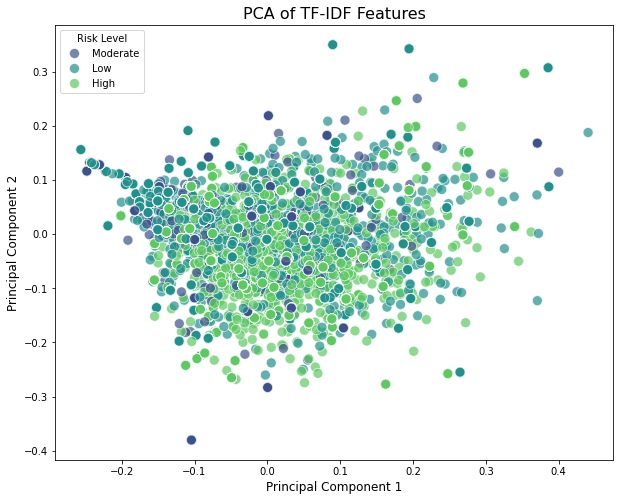

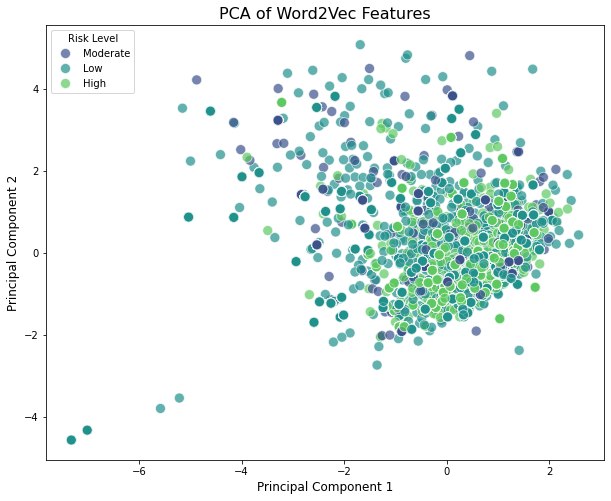

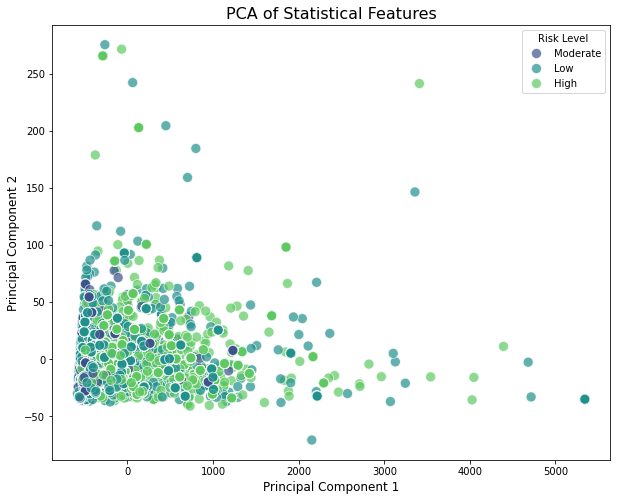

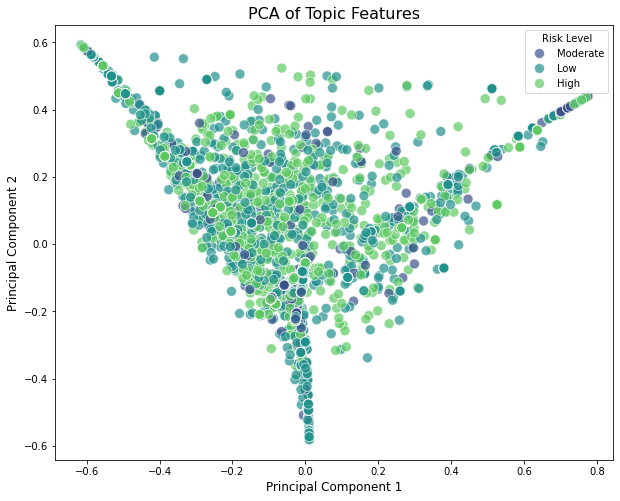

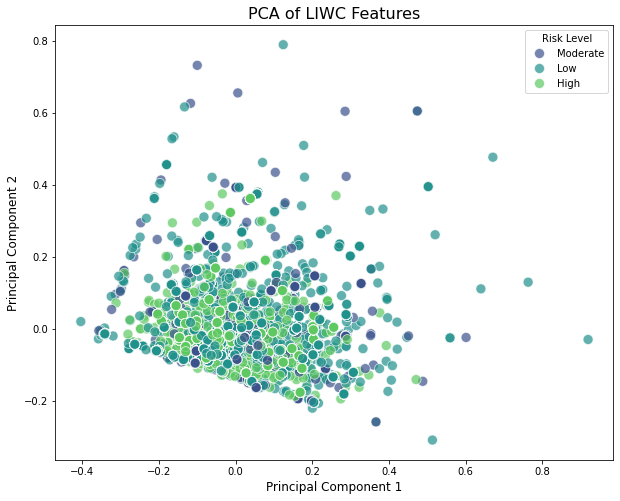

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Step 1: Apply PCA for each feature set separately

# 1. PCA for TF-IDF features
pca_tfidf = PCA(n_components=2)
reduced_tfidf = pca_tfidf.fit_transform(tfidf_matrix.toarray())

# 2. PCA for Word2Vec features
pca_word2vec = PCA(n_components=2)
reduced_word2vec = pca_word2vec.fit_transform(word2vec_matrix)

# 3. PCA for Statistical features
pca_statistical = PCA(n_components=2)
reduced_statistical = pca_statistical.fit_transform(statistical_features)

# 4. PCA for Topic features (LDA topics)
pca_topics = PCA(n_components=2)
reduced_topics = pca_topics.fit_transform(lda_topics)

# 5. PCA for N-gram features (trigrams)
# pca_ngram = PCA(n_components=2)
# reduced_ngram = pca_ngram.fit_transform(ngram_matrix.toarray())

# Step 2: Create DataFrames for easier visualization
df_tfidf = pd.DataFrame(reduced_tfidf, columns=['PCA1', 'PCA2'])
df_tfidf['Risk_Level'] = df_posts['Risk_Level']

df_word2vec = pd.DataFrame(reduced_word2vec, columns=['PCA1', 'PCA2'])
df_word2vec['Risk_Level'] = df_posts['Risk_Level']

df_statistical = pd.DataFrame(reduced_statistical, columns=['PCA1', 'PCA2'])
df_statistical['Risk_Level'] = df_posts['Risk_Level']

df_topics = pd.DataFrame(reduced_topics, columns=['PCA1', 'PCA2'])
df_topics['Risk_Level'] = df_posts['Risk_Level']

# df_ngram = pd.DataFrame(reduced_ngram, columns=['PCA1', 'PCA2'])
# df_ngram['Risk_Level'] = df_posts['Risk_Level']

# Step 3: Visualize each feature set separately

# Plot for TF-IDF features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_tfidf, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of TF-IDF Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Word2Vec features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_word2vec, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Word2Vec Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Statistical features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_statistical, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Statistical Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Topic features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_topics, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Topic Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for N-gram (trigram) features
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_ngram, palette='viridis', s=100, alpha=0.7)
# plt.title('PCA of N-gram (Trigram) Features', fontsize=16)
# plt.xlabel('Principal Component 1', fontsize=12)
# plt.ylabel('Principal Component 2', fontsize=12)
# plt.legend(title='Risk Level', loc='best')
# plt.show()


# Perform PCA for LIWC features
liwc_columns = liwc_features_df.columns  # These are the columns with LIWC features
pca_liwc = PCA(n_components=2)
reduced_liwc = pca_liwc.fit_transform(df_posts[liwc_columns])

# Create a DataFrame for the reduced LIWC features
df_liwc = pd.DataFrame(reduced_liwc, columns=['PCA1', 'PCA2'])
df_liwc['Risk_Level'] = df_posts['Risk_Level']

# Plot for LIWC features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_liwc, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of LIWC Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()



<h2>Classification Models </h2>

In [29]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure the target variable 'Risk_Level' does not contain NaN values
df_posts_clean = df_posts.dropna(subset=['Risk_Level'])

# Encode target variable as numerical labels (Low=0, Moderate=1, High=2)
df_posts_clean['Risk_Level'] = df_posts_clean['Risk_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

# Step 2: Feature extraction
# Combine TF-IDF and Word2Vec matrices (assuming 'combined_features' is already created)
X = combined_features  # Features: concatenated TF-IDF + Word2Vec embeddings
y = df_posts_clean['Risk_Level']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h4>XGBoost Model</h4>

https://www.mdpi.com/1660-4601/19/19/12635

Accuracy: 0.947

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       940
           1       0.99      0.84      0.91       231
           2       0.95      0.95      0.95       829

    accuracy                           0.95      2000
   macro avg       0.96      0.92      0.94      2000
weighted avg       0.95      0.95      0.95      2000



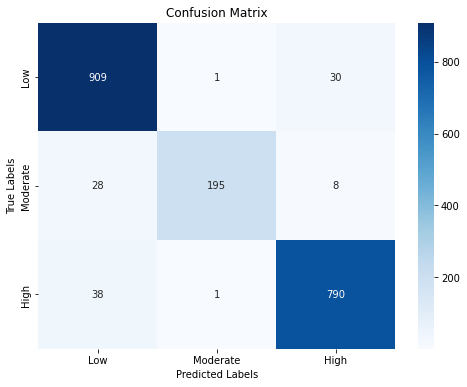

In [30]:

# Step 3: Train the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



<h2>BERT model</h2>

In [19]:
from transformers import BertTokenizer, BertModel

# Step 1: Load pre-trained BERT tokenizer
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    print("BERT Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading BERT Tokenizer: {e}")

# Step 2: Load pre-trained BERT model
try:
    model = BertModel.from_pretrained('bert-base-uncased')
    print("BERT Model loaded successfully.")
except Exception as e:
    print(f"Error loading BERT Model: {e}")

# Step 3: Test tokenization and model output
try:
    # Example text
    text = "This is a test to see if BERT works correctly."

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt")
    print(f"Tokenized input: {inputs}")

    # Pass tokenized input through the BERT model
    outputs = model(**inputs)
    print("Model output keys:", outputs.keys())  # Should display 'last_hidden_state' and 'pooler_output'
    print("BERT Model test successful.")
except Exception as e:
    print(f"Error using BERT Model: {e}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT Tokenizer loaded successfully.
BERT Model loaded successfully.
Tokenized input: {'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  2000,  2156,  2065, 14324,  2573,
         11178,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Model output keys: odict_keys(['last_hidden_state', 'pooler_output'])
BERT Model test successful.


Columns in the DataFrame: Index(['User', 'Post Title', 'Content', 'Score', 'Comments Count',
       'Upvote Ratio', 'Date', 'Post ID', 'SpaCy_Word_Tokens',
       'SpaCy_Sentence_Tokens',
       ...
       'swear_words', 'family', 'friend', 'female_references',
       'male_references', 'work', 'money', 'past_focus', 'present_focus',
       'future_focus'],
      dtype='object', length=116)
Extracting BERT embeddings in batches...
BERT embeddings extraction complete.
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       940
           1       0.91      0.86      0.88       231
           2       0.94      0.96      0.95       829

    accuracy                           0.94      2000
   macro avg       0.93      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy: 0.94


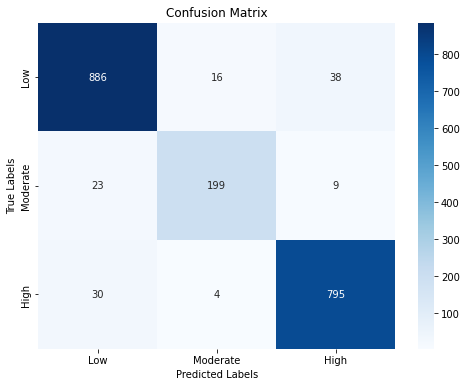

In [44]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the required columns exist
print("Columns in the DataFrame:", df_posts.columns)

# Check for missing columns
required_columns = ['Processed_Text', 'Risk_Level']
for col in required_columns:
    if col not in df_posts.columns:
        raise KeyError(f"Column '{col}' is missing in the DataFrame. Please verify the preprocessing steps.")

# Map risk levels to numerical labels if not already mapped
if df_posts['Risk_Level'].dtype == 'object':
    df_posts['Risk_Level'] = df_posts['Risk_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

# Drop rows with missing values in required columns
df_posts = df_posts.dropna(subset=['Processed_Text', 'Risk_Level'])

# Step 1: Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set model to evaluation mode

# Step 2: Define a Dataset class for BERT embeddings
class BERTDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        return self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )

# Step 3: Extract BERT embeddings in batches

def extract_bert_embeddings(dataloader, model):
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].squeeze(1).to(model.device)  # Adjust for batch shape
            attention_mask = batch['attention_mask'].squeeze(1).to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state
            pooled_embeddings = torch.mean(hidden_states, dim=1)  # Mean pooling
            embeddings.extend(pooled_embeddings.cpu().numpy())
    return embeddings

# Prepare the dataset and dataloader
texts = df_posts['Processed_Text'].tolist()
dataset = BERTDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

print("Extracting BERT embeddings in batches...")
bert_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move model to GPU if available
bert_embeddings = extract_bert_embeddings(dataloader, bert_model)
print("BERT embeddings extraction complete.")

# Add embeddings back to the DataFrame
df_posts['BERT_Embeddings'] = bert_embeddings

# Convert embeddings to a matrix
X = torch.stack([torch.tensor(embedding) for embedding in bert_embeddings]).numpy()
y = df_posts['Risk_Level'].values

# Step 4: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train a classifier on BERT embeddings
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Make predictions and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 7: Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Save the Model

In [47]:
import joblib

# Save the trained model to a file
joblib.dump(clf, 'bert_logistic_model.pkl')
print("Model saved successfully.")

Model saved successfully.


Load the Model

In [48]:
# Load the model from the file
loaded_model = joblib.load('bert_logistic_model.pkl')
print("Model loaded successfully.")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
print("Accuracy of loaded model:", accuracy_score(y_test, y_pred_loaded))

Model loaded successfully.
Accuracy of loaded model: 0.94


Save and Load BERT Embeddings

In [49]:
# Save BERT embeddings
import numpy as np
np.save('bert_embeddings.npy', X)

# Save labels
np.save('labels.npy', y)

# Load BERT embeddings and labels
X_loaded = np.load('bert_embeddings.npy')
y_loaded = np.load('labels.npy')